In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("Titanic-Dataset.csv")
col_target = 'survived'

# Hiển thị 5 dòng đầu tiên
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [43]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Nhận biết những cột không có ý nghĩa, để xóa
def detect_useless_columns(df, uniqueness_thresh=0.95):
    drop_cols = []
    n_rows = len(df)
    
    for col in df.columns:
        nunique = df[col].nunique()
        ratio_unique = nunique / n_rows
        
        if df[col].dtype in ['object', 'category'] and ratio_unique > uniqueness_thresh:
                drop_cols.append(col)
        #elif any(key in col.lower() for key in ['id', 'name']):
        elif col.lower() in ['id', 'name', 'passengerid']:
            drop_cols.append(col)
    
    return drop_cols

def auto_clean(df, target_col):
    # 1. Chuẩn hóa tên cột
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

    # 2. Loại bỏ cột trống hoàn toàn
    df = df.dropna(axis=1, how='all')

    # 3. Loại bỏ dòng trống hoàn toàn hoặc có số mẫu ít hơn 10
    df = df.dropna(axis=0, how='all')
    value_counts = df[col_target].value_counts()
    valid_classes = value_counts[value_counts >= 10].index
    df = df[df[col_target].isin(valid_classes)].copy()

    # 4. Loại bỏ trùng lặp
    df = df.drop_duplicates()

    # 5. Làm sạch chuỗi
    for col in df.select_dtypes(include='object'):
        df[col] = df[col].str.strip()

    # 6. Xóa cột không cần thiết
    drop_cols = detect_useless_columns(df)
    df = df.drop(columns=drop_cols)

    # 7. Phân chia X và y nếu có
    has_target = target_col in df.columns
    features_df = df.drop(columns=[target_col]) if has_target else df.copy()

    # 8. Xác định cột phân loại và số
    categorical_cols = features_df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = features_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Nếu cột numeric có ít unique → cũng coi là categorical
    for col in features_df.columns:
        if features_df[col].nunique() < 10 and features_df[col].dtype != 'object':
            if col not in categorical_cols:
                categorical_cols.append(col)
            if col in numerical_cols:
                numerical_cols.remove(col)

    # 9. Encode categorical
    for col in categorical_cols:
        features_df[col] = LabelEncoder().fit_transform(features_df[col])

    # 10. Chuẩn hóa đặc trưng số
    if numerical_cols:
        scaler = StandardScaler()
        features_df[numerical_cols] = scaler.fit_transform(features_df[numerical_cols])

    # 11. Thêm lại cột target nếu có
    if has_target:
        cleaned_df = features_df.copy()
        y = df[target_col]

        # Nếu y không phải số nguyên, hoặc không liên tiếp từ 0 → encode
        if y.dtype == 'object' or y.dtype.name == 'category' or not np.issubdtype(y.dtype, np.integer):
            le = LabelEncoder()
            y = le.fit_transform(y)
            cleaned_df[target_col] = y
        else:
            cleaned_df[target_col] = y
    else:
        return features_df
    
    return cleaned_df

df_prf = auto_clean(df, target_col=col_target)

df_prf

,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
0,2,1,-0.530377,1,0,523,-0.502445,147,2,0
1,0,0,0.571831,1,0,596,0.786845,81,0,1
2,2,0,-0.254825,0,0,669,-0.488854,147,2,1
3,0,0,0.365167,1,0,49,0.420730,55,2,1
4,2,1,0.365167,0,0,472,-0.486337,147,2,0
...,...,...,...,...,...,...,...,...,...,...
886,1,1,-0.185937,0,0,101,-0.386671,147,2,0
887,0,0,-0.737041,0,0,14,-0.044381,30,2,1
888,2,0,NaN,1,2,675,-0.176263,147,2,0
889,0,1,-0.254825,0,0,8,-0.044381,60,0,1


In [44]:
# Bản dữ liệu cho SVM, RF, XGBoost (impute NaN)
df_cleaned = df_prf.copy()
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(df_cleaned.drop(columns=col_target))
df_noprf = pd.DataFrame(X_imputed, columns=df_cleaned.columns[:-1])
df_noprf[col_target] = df_cleaned[col_target].values

df_noprf

,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
0,2.0,1.0,-0.530377,1.0,0.0,523.0,-0.502445,147.0,2.0,0
1,0.0,0.0,0.571831,1.0,0.0,596.0,0.786845,81.0,0.0,1
2,2.0,0.0,-0.254825,0.0,0.0,669.0,-0.488854,147.0,2.0,1
3,0.0,0.0,0.365167,1.0,0.0,49.0,0.420730,55.0,2.0,1
4,2.0,1.0,0.365167,0.0,0.0,472.0,-0.486337,147.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...
886,1.0,1.0,-0.185937,0.0,0.0,101.0,-0.386671,147.0,2.0,0
887,0.0,0.0,-0.737041,0.0,0.0,14.0,-0.044381,30.0,2.0,1
888,2.0,0.0,-0.117049,1.0,2.0,675.0,-0.176263,147.0,2.0,0
889,0.0,1.0,-0.254825,0.0,0.0,8.0,-0.044381,60.0,0.0,1


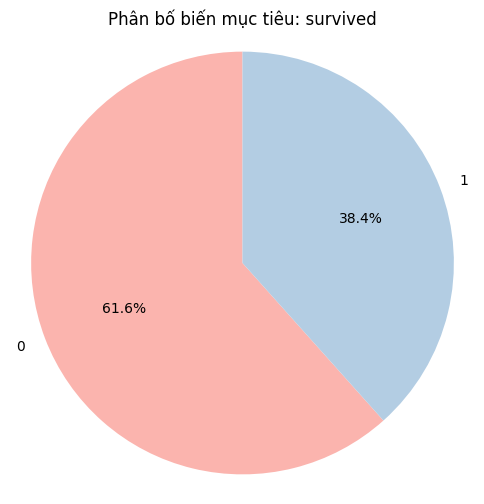

In [33]:
import matplotlib.pyplot as plt

def plot_target_pie(df, target_col):
    if target_col not in df.columns:
        print(f"Không tìm thấy cột '{target_col}' trong DataFrame.")
        return

    counts = df[target_col].value_counts()
    labels = counts.index.astype(str)
    sizes = counts.values

    plt.figure(figsize=(6,6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
    plt.title(f'Phân bố biến mục tiêu: {target_col}')
    plt.axis('equal')  # Đảm bảo hình tròn
    plt.show()

plot_target_pie(df, target_col=col_target)

In [6]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, log_loss, brier_score_loss, recall_score, f1_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import KFold   # Dùng để tạo py
from PRF import prf

In [45]:
X = df_noprf.drop(columns=[col_target])  # Drop the target column for features
y = df_noprf[col_target]
X = X.values if isinstance(X, pd.DataFrame) else X
y = y.values if isinstance(y, pd.Series) else y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [46]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=10, random_state=42)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)
y_proba = model_rf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
lloss = log_loss(y_test, y_proba)

print(f"RF Accuracy: {accuracy:.2f}")
print(f"RF F1 Score: {f1_macro:.2f}")
print(f"RF Log Loss: {lloss:.4f}")
print(classification_report(y_test, y_pred, digits=3))

RF Accuracy: 0.81
RF F1 Score: 0.79
RF Log Loss: 0.4682
              precision    recall  f1-score   support

           0      0.811     0.900     0.853       110
           1      0.807     0.667     0.730        69

    accuracy                          0.810       179
   macro avg      0.809     0.783     0.792       179
weighted avg      0.810     0.810     0.806       179



In [47]:
model_svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
model_svm.fit(X_train, y_train)

y_pred = model_svm.predict(X_test)
y_proba = model_svm.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
lloss = log_loss(y_test, y_proba)

print(f"SVM Accuracy: {accuracy:.2f}")
print(f"SVM F1 Score: {f1_macro:.2f}")
print(f"SVM Log Loss: {lloss:.4f}")
print(classification_report(y_test, y_pred, digits=3))

SVM Accuracy: 0.64
SVM F1 Score: 0.58
SVM Log Loss: 0.6363
              precision    recall  f1-score   support

           0      0.664     0.845     0.744       110
           1      0.564     0.319     0.407        69

    accuracy                          0.642       179
   macro avg      0.614     0.582     0.576       179
weighted avg      0.626     0.642     0.614       179



In [48]:
model_xgb = XGBClassifier(n_estimators=100, max_depth=8, min_child_weight=10, learning_rate=0.1, eval_metric='mlogloss', random_state=42)
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)
y_proba = model_xgb.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
lloss = log_loss(y_test, y_proba)

print(f"XGB Accuracy: {accuracy:.2f}")
print(f"XGB F1 Score: {f1_macro:.2f}")
print(f"XGB Log Loss: {lloss:.4f}")
print(classification_report(y_test, y_pred, digits=3))

XGB Accuracy: 0.80
XGB F1 Score: 0.79
XGB Log Loss: 0.4377
              precision    recall  f1-score   support

           0      0.810     0.891     0.848       110
           1      0.793     0.667     0.724        69

    accuracy                          0.804       179
   macro avg      0.802     0.779     0.786       179
weighted avg      0.803     0.804     0.801       179



In [49]:
X = df_prf.drop(columns=[col_target])  # Drop the target column for features
y = df_prf[col_target]
X = X.values if isinstance(X, pd.DataFrame) else X
y = y.values if isinstance(y, pd.Series) else y

In [50]:
# Tính noise_level khi missing data

from sklearn.ensemble import IsolationForest

def safe_impute(X, strategy="median"):
    X = X.copy()
    from sklearn.impute import SimpleImputer
    imp = SimpleImputer(strategy=strategy)
    return imp.fit_transform(X)

def estimate_noise_level_from_outliers(X):
    X_filled = safe_impute(X, strategy='median')
    iso = IsolationForest(contamination=0.1, random_state=42)
    preds = iso.fit_predict(X_filled)
    outlier_ratio = np.mean(preds == -1)
    return np.clip(outlier_ratio * 2.0, 0.01, 1.0)

def estimate_noise_level_from_variance(X):
    X_filled = np.nan_to_num(X, nan=0.0)  # hoặc median nếu bạn muốn chính xác hơn
    stds = np.std(X_filled, axis=0)
    means = np.mean(np.abs(X_filled), axis=0) + 1e-6
    relative_noise = stds / means
    return np.clip(relative_noise.mean(), 0.01, 1.0)

def estimate_noise_level(X):
    var_score = estimate_noise_level_from_variance(X)
    outlier_score = estimate_noise_level_from_outliers(X)
    return np.clip((var_score + outlier_score) / 2, 0.01, 1.0)

# Gán độ nhiễu tương ứng
noise_level = estimate_noise_level(X)
dX = noise_level * np.abs(np.nan_to_num(X, nan=1.0)) + 0.01

noise_level

np.float64(0.5998877665544332)

In [51]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
n_classes = len(np.unique(y))
py = np.zeros((len(X), n_classes))

for train_idx, val_idx in kf.split(X):
    rf = RandomForestClassifier(n_estimators=50, max_depth=8, n_jobs=-1, random_state=41)
    rf.fit(X[train_idx], y[train_idx])
    py[val_idx] = rf.predict_proba(X[val_idx])

py

array([[0.8931902 , 0.1068098 ],
       [0.09182963, 0.90817037],
       [0.55515163, 0.44484837],
       ...,
       [0.57883244, 0.42116756],
       [0.66316584, 0.33683416],
       [0.89813586, 0.10186414]], shape=(891, 2))

In [52]:
X_train, X_test, dX_train, dX_test, py_train, py_test = train_test_split(
    X, dX, py, test_size=0.2, random_state=40, stratify=np.argmax(py, axis=1)
)

model_prf = prf(n_estimators=100, bootstrap=True, max_depth=8, keep_proba=1.0, n_jobs=-1)
model_prf.fit(X=X_train, dX=dX_train, py=py_train)

y_test_bin = py_test.argmax(axis=1)
y_proba_prf = np.array(model_prf.predict_proba(X_test, dX=dX_test))
y_pred_prf = y_proba_prf.argmax(axis=1)
f1_macro = f1_score(y_test_bin, y_pred_prf, average='macro')
lloss = log_loss(y_test_bin, y_proba_prf)

print("PRF Accuracy:", model_prf.score(X_test, dX=dX_test, y=y_test_bin))
print(f"PRF F1 Score: {f1_macro:.2f}")
print(f"PRF Log Loss: {lloss:.4f}")
print(classification_report(y_test_bin, y_pred_prf, digits=3))

PRF Accuracy: 0.9385474860335196
PRF F1 Score: 0.93
PRF Log Loss: 0.2794
              precision    recall  f1-score   support

           0      0.943     0.967     0.955       120
           1      0.929     0.881     0.904        59

    accuracy                          0.939       179
   macro avg      0.936     0.924     0.930       179
weighted avg      0.938     0.939     0.938       179

